### ***About the Data***
*These images consist of gaussian filtered retina scan images to detect diabetic retinopathy, and the original dataset is available at [APTOS 2019 Blindness Detection](https://www.kaggle.com/c/aptos2019-blindness-detection/overview). These images are resized into 224x224 pixels so that they can be readily used with many pre-trained deep learning models.*

> |> *There are five image directories:*
* *0 -> No_DR*
* *1 -> Mild*
* *2 -> Moderate*
* *3 -> Severe*
* *4 -> Proliferate_DR*

---

In [1]:
import sys
import os.path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from time import perf_counter
from pathlib import Path
from IPython.display import Image, display, Markdown

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import tensorflow as tf

import seaborn as sns

In [2]:
def printmd(string):
    display(Markdown(string))

In [3]:
imageDir = Path('data\gaussian_filtered_images')

filepaths = list(imageDir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

In [4]:
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

image_df = pd.concat([filepaths, labels], axis=1)
image_df = image_df.sample(frac=1).reset_index(drop = True)

image_df

Filepath  Label
0     data\gaussian_filtered_images\gaussian_filtere...     DR
1     data\gaussian_filtered_images\gaussian_filtere...     DR
2     data\gaussian_filtered_images\gaussian_filtere...     DR
3     data\gaussian_filtered_images\gaussian_filtere...     DR
4     data\gaussian_filtered_images\gaussian_filtere...  No_DR
...                                                 ...    ...
3657  data\gaussian_filtered_images\gaussian_filtere...     DR
3658  data\gaussian_filtered_images\gaussian_filtere...     DR
3659  data\gaussian_filtered_images\gaussian_filtere...     DR
3660  data\gaussian_filtered_images\gaussian_filtere...     DR
3661  data\gaussian_filtered_images\gaussian_filtere...     DR

[3662 rows x 2 columns]

## ***1. Visualization***<a class="anchor" id="1"></a>

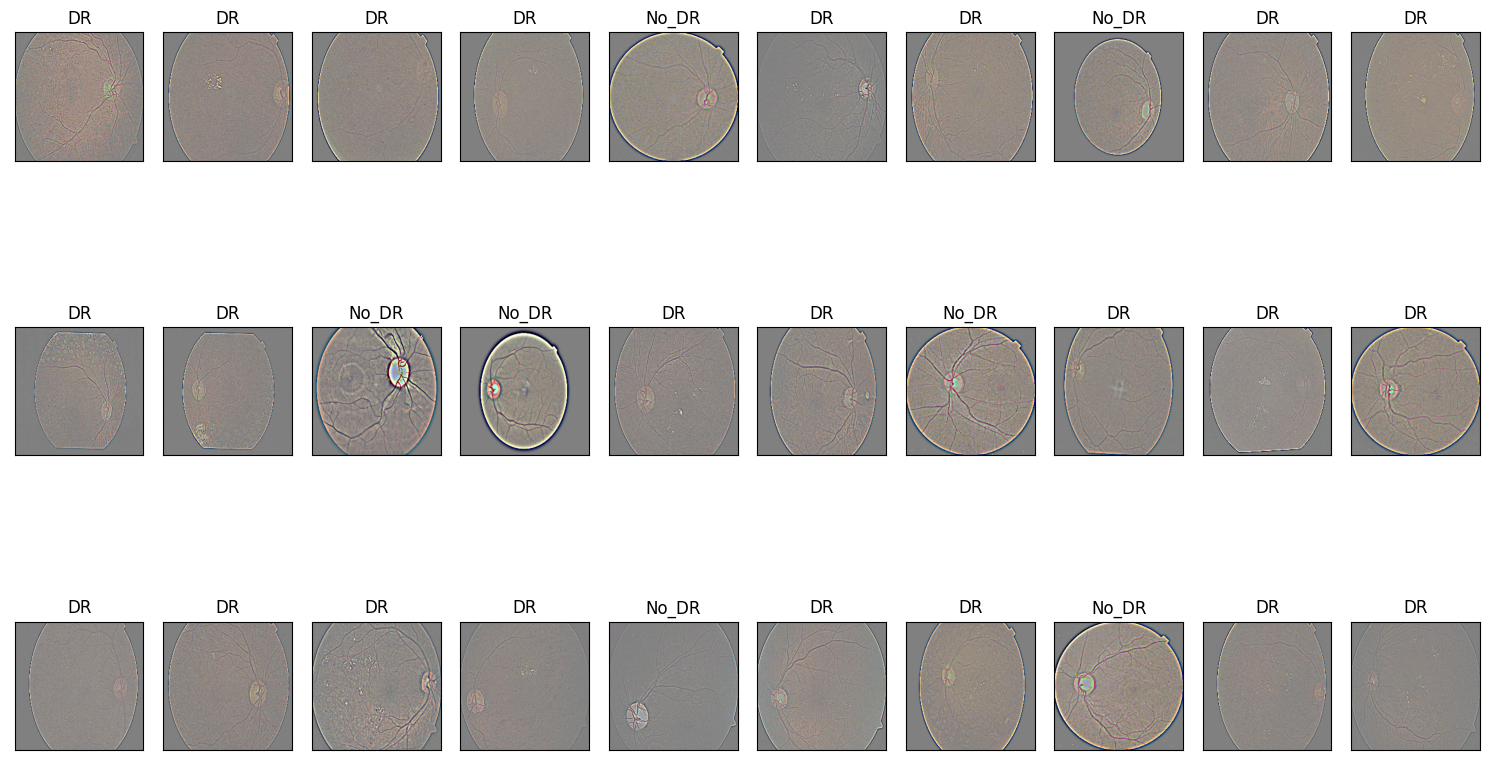

In [5]:
fig, axes = plt.subplots(nrows=3, ncols=10, figsize=(15, 10), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[i]))
    ax.set_title(image_df.Label[i])

plt.tight_layout()
plt.show()

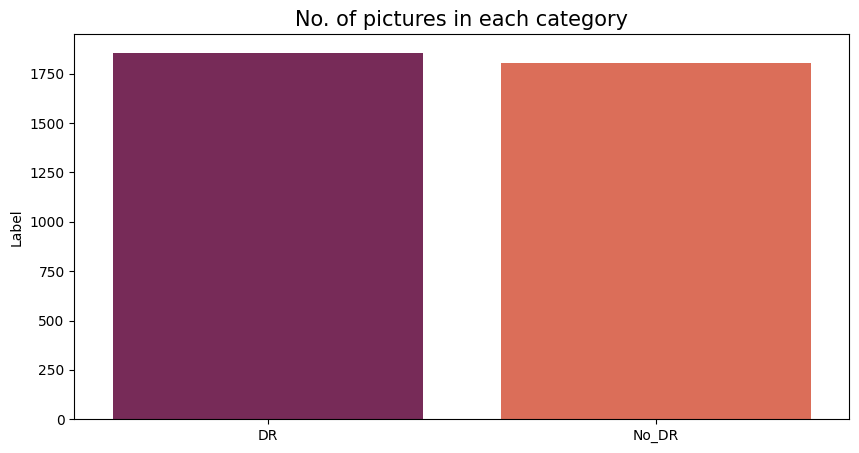

In [6]:
vc = image_df['Label'].value_counts()
plt.figure(figsize=(10, 5))
sns.barplot(x=vc.index, y=vc, palette="rocket")
plt.title("No. of pictures in each category", fontsize=15)
plt.show()

## ***2. Load the Images with a generator***<a class="anchor" id="2"></a>

In [7]:
def createGen():
    trainGen = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.1
    )

    testGen = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    trainImages = trainGen.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='training',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    valImages = trainGen.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='validation',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    testImages = testGen.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )
    
    return trainGen, testGen, trainImages, valImages, testImages

## ***3. Test 27 canned architectures with pretrained weights***<a class="anchor" id="3"></a>

In [8]:
def getModel(model):
    kwargs = {
        'input_shape':(224, 224, 3),
        'include_top':False,
        'weights':'imagenet',
        'pooling':'avg'
    }
    
    pretrained_model = model(**kwargs)
    pretrained_model.trainable = False
    
    inputs = pretrained_model.input

    x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    outputs = tf.keras.layers.Dense(2, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [9]:
train_df, test_df = train_test_split(image_df, train_size=0.9, shuffle=True, random_state=1)

In [10]:
models = {
    "MobileNet": {"model":tf.keras.applications.MobileNet, "perf":0},
    "ResNet50": {"model":tf.keras.applications.ResNet50, "perf":0},
    "VGG16": {"model":tf.keras.applications.VGG16, "perf":0},
}

In [11]:
trainGen, testGen, trainImages, valImages, testImages = createGen()

for name, model in models.items():
    X = getModel(model['model'])
    models[name]['model'] = X
    
    start = perf_counter()
    history = X.fit(trainImages, validation_data=valImages, epochs=10)
    
    duration = round((perf_counter() - start), 2)
    models[name]['perf'] = duration
    print(f"{name:20} -> trained in -> {duration} Sec")
    
    valAcc = history.history['val_accuracy']
    models[name]['val_acc'] = [round(v, 4) for v in valAcc]
    
    trainAcc = history.history['accuracy']
    models[name]['train_accuracy'] = [round(v, 4) for v in trainAcc]

Found 2966 validated image filenames belonging to 2 classes.
Found 329 validated image filenames belonging to 2 classes.
Found 367 validated image filenames belonging to 2 classes.
Epoch 1/10
93/93 [==============================] - 48s 493ms/step - loss: 0.1972 - accuracy: 0.9241 - val_loss: 0.0940 - val_accuracy: 0.9666
Epoch 2/10
93/93 [==============================] - 33s 359ms/step - loss: 0.1283 - accuracy: 0.9572 - val_loss: 0.0708 - val_accuracy: 0.9848
Epoch 3/10
93/93 [==============================] - 33s 360ms/step - loss: 0.1097 - accuracy: 0.9626 - val_loss: 0.0601 - val_accuracy: 0.9818
Epoch 4/10
93/93 [==============================] - 33s 353ms/step - loss: 0.0981 - accuracy: 0.9659 - val_loss: 0.0663 - val_accuracy: 0.9757
Epoch 5/10
93/93 [==============================] - 33s 357ms/step - loss: 0.0887 - accuracy: 0.9690 - val_loss: 0.0627 - val_accuracy: 0.9757
Epoch 6/10
93/93 [==============================] - 33s 355ms/step - loss: 0.0795 - accuracy: 0.9693 - v

In [12]:
modelsResult = []

for name, v in models.items():
    modelsResult.append(
        [
            name,
            models[name]['train_accuracy'][-1],
            models[name]['val_acc'][-1],
            models[name]['perf']
        ]
    )
    
dfResults = pd.DataFrame(
    modelsResult,
    columns = [
        'Model',
        'train_accuracy',
        'val_accuracy',
        'Training time (sec)'
    ]
)

dfResults.sort_values(by='val_accuracy', ascending=False, inplace=True)
dfResults.reset_index(inplace=True, drop=True)
dfResults

Model  train_accuracy  val_accuracy  Training time (sec)
0  MobileNet          0.9845        0.9726               346.18
1      VGG16          0.9494        0.9726              1862.91
2   ResNet50          0.9171        0.9210              1176.55

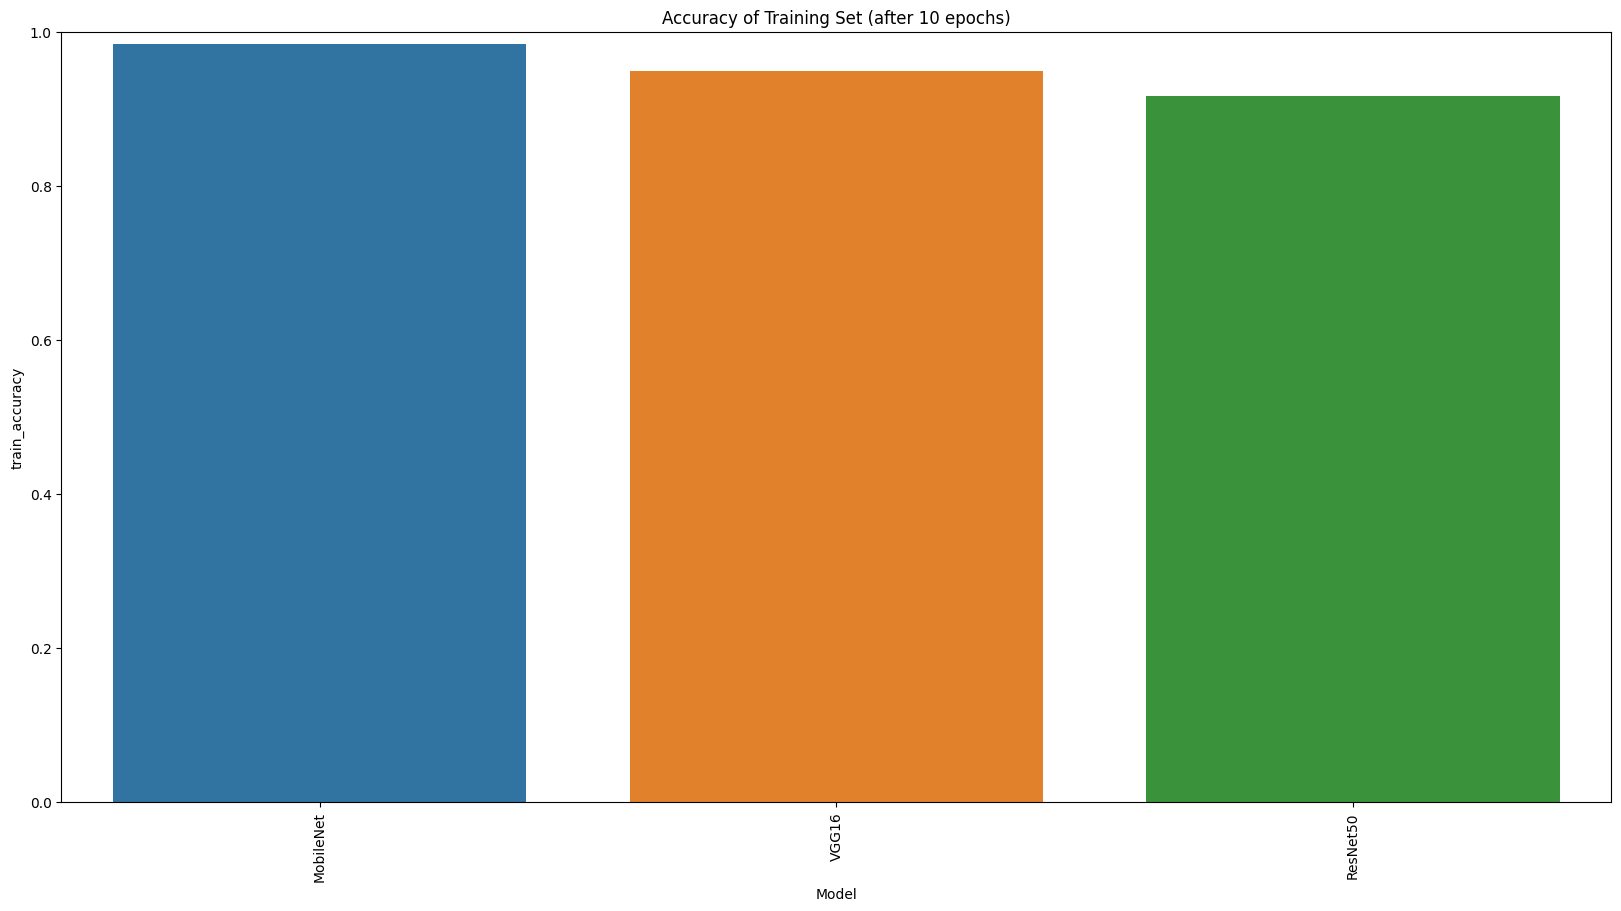

In [13]:
plt.figure(figsize=(20, 10))
plt.title('Accuracy of Training Set (after 10 epochs)', fontsize=12)
sns.barplot(x='Model', y='train_accuracy', data=dfResults)
plt.ylim(0, 1)
plt.xticks(rotation=90)
plt.show()

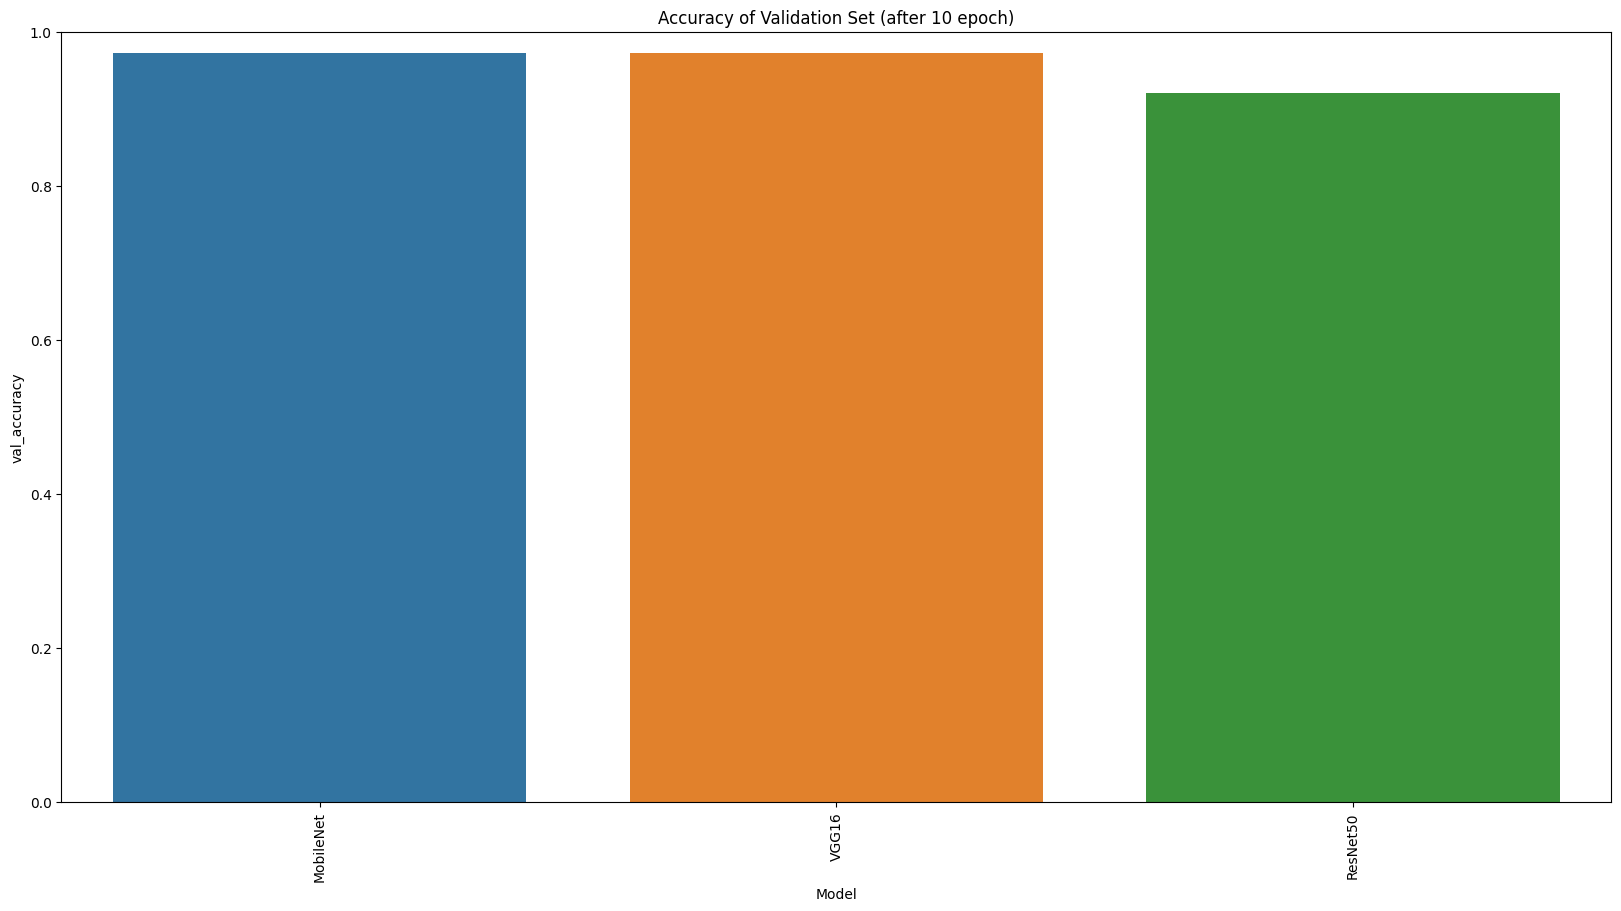

In [14]:
plt.figure(figsize=(20, 10))
plt.title('Accuracy of Validation Set (after 10 epoch)', fontsize=12)
sns.barplot(x='Model', y='val_accuracy', data=dfResults)
plt.ylim(0,1)
plt.xticks(rotation=90)
plt.show()

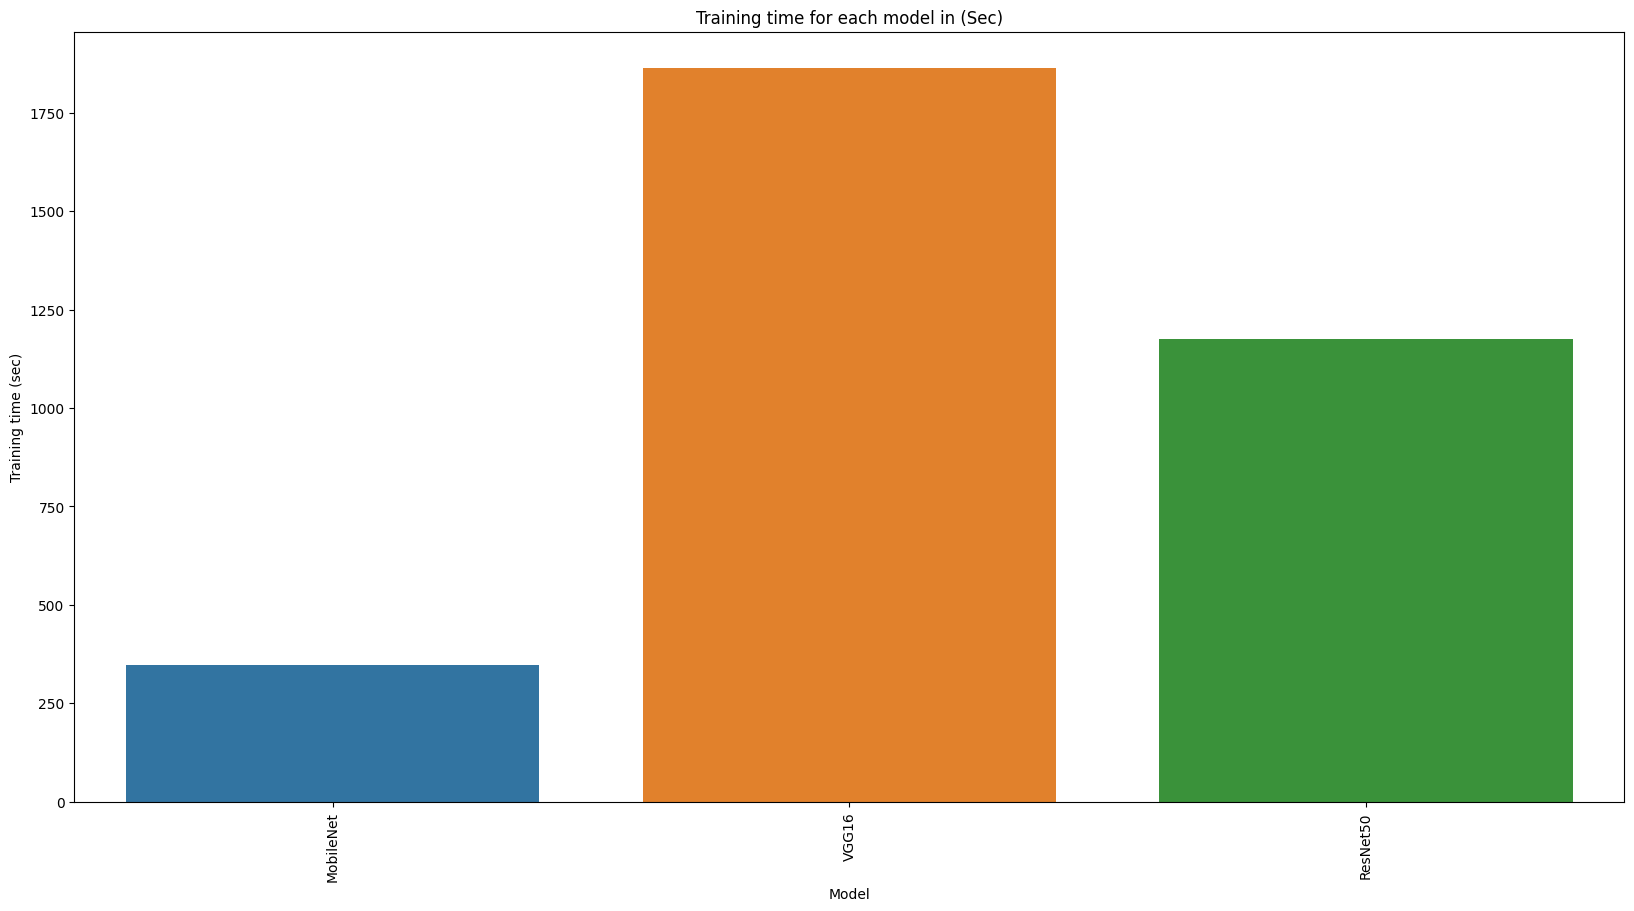

In [15]:
plt.figure(figsize=(20, 10))
sns.barplot(x='Model', y='Training time (sec)', data=dfResults)
plt.title('Training time for each model in (Sec)', fontsize=12)
plt.xticks(rotation=90)
plt.show()

## ***4. Train the model MobileNetV2***<a class="anchor" id="4"></a>

In [16]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

In [17]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(2, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    trainImages,
    validation_data=valImages,
    batch_size = 32,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

Epoch 1/10
93/93 [==============================] - 41s 423ms/step - loss: 0.2139 - accuracy: 0.9272 - val_loss: 0.1223 - val_accuracy: 0.9787
Epoch 2/10
93/93 [==============================] - 39s 421ms/step - loss: 0.1573 - accuracy: 0.9488 - val_loss: 0.0953 - val_accuracy: 0.9726
Epoch 3/10
93/93 [==============================] - 39s 418ms/step - loss: 0.1236 - accuracy: 0.9589 - val_loss: 0.1156 - val_accuracy: 0.9696
Epoch 4/10
93/93 [==============================] - 40s 429ms/step - loss: 0.1121 - accuracy: 0.9626 - val_loss: 0.0821 - val_accuracy: 0.9787
Epoch 5/10
93/93 [==============================] - 39s 417ms/step - loss: 0.0990 - accuracy: 0.9663 - val_loss: 0.1060 - val_accuracy: 0.9696
Epoch 6/10
93/93 [==============================] - 39s 418ms/step - loss: 0.0971 - accuracy: 0.9680 - val_loss: 0.0836 - val_accuracy: 0.9757


In [18]:
model.save("binary.h5")

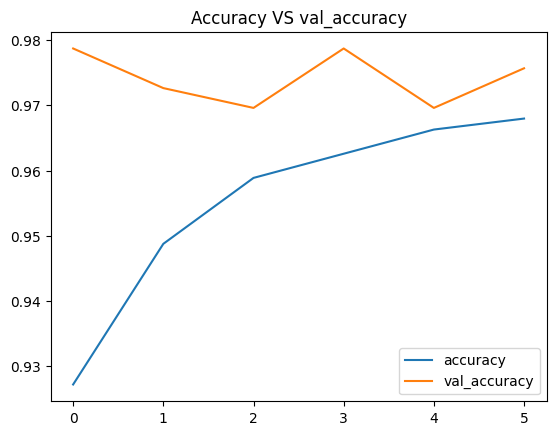

In [19]:
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
plt.title("Accuracy VS val_accuracy")
plt.show()

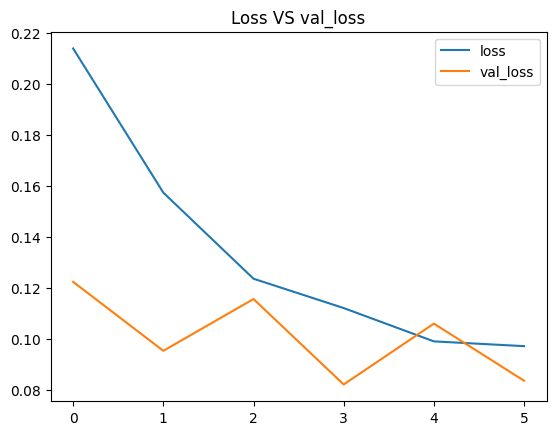

In [20]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss VS val_loss")
plt.show()

## ***5. Visualize the result***<a class="anchor" id="5"></a>

In [21]:
results = model.evaluate(testImages, verbose=0)

printmd('> ## Test Loss |> {:.5f}'.format(results[0]))
printmd('> ## Accuracy |> {:.2f}%'.format(results[1] *100))

> ## Test Loss |> 0.12515

> ## Accuracy |> 95.91%

In [22]:
pred = model.predict(testImages)
pred = np.argmax(pred,axis=1)

labels = (trainImages.class_indices)
labels = dict((v, k) for k, v in labels.items())

pred = [labels[k] for k in pred]

print(f'The first 10 predictions:\n{pred[:10]}')

12/12 [==============================] - 5s 370ms/step
The first 10 predictions:
['No_DR', 'No_DR', 'No_DR', 'No_DR', 'No_DR', 'No_DR', 'DR', 'DR', 'DR', 'No_DR']


In [23]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

          DR       0.98      0.94      0.96       182
       No_DR       0.94      0.98      0.96       185

    accuracy                           0.96       367
   macro avg       0.96      0.96      0.96       367
weighted avg       0.96      0.96      0.96       367



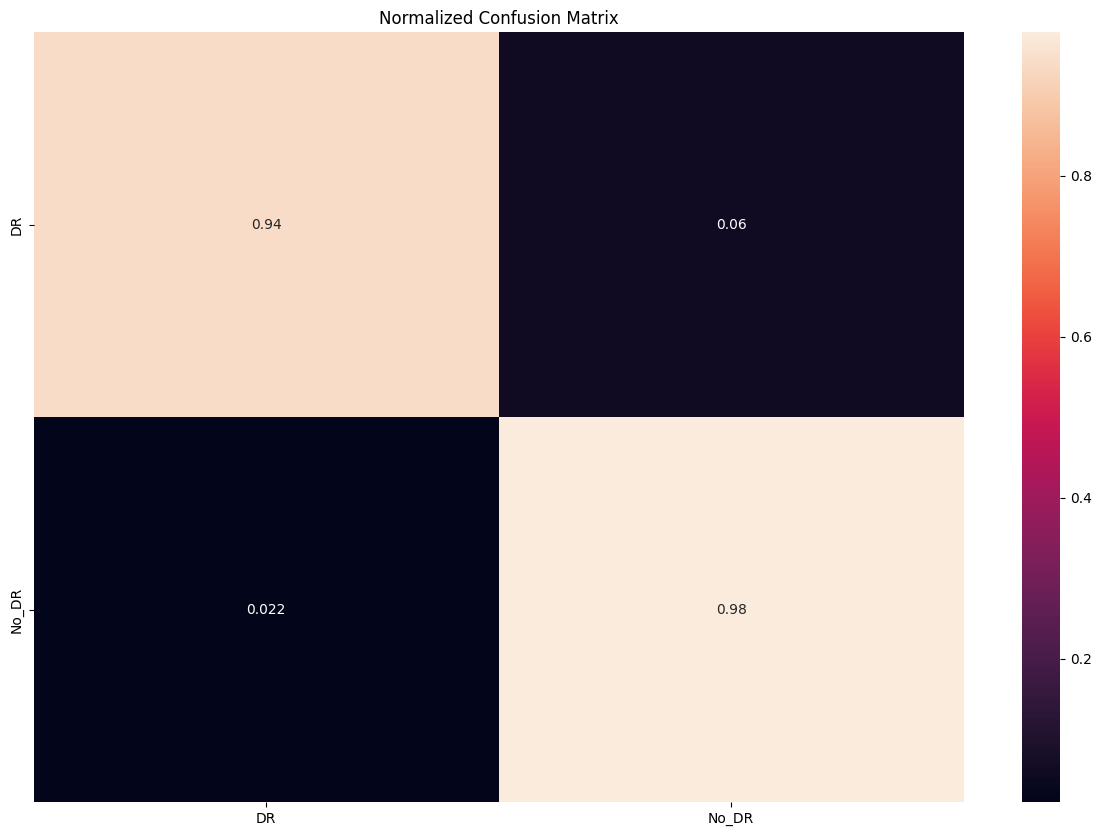

In [24]:
cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (15, 10))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

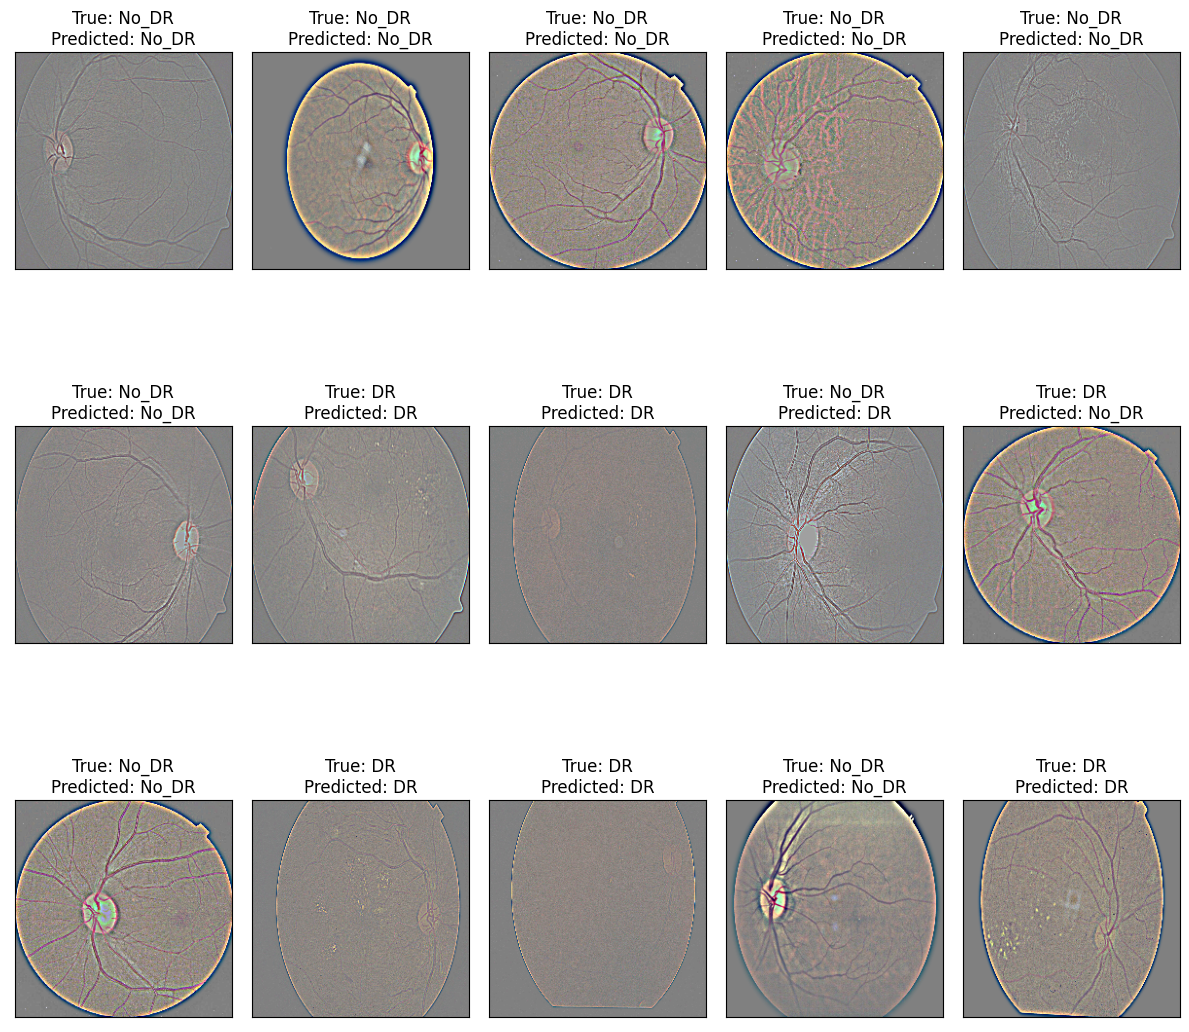

In [25]:
fig, axes = plt.subplots(
    nrows=3, ncols=5,
    figsize=(12, 12),
    subplot_kw={'xticks':[], 'yticks':[]}
)

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f'True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}')

plt.tight_layout()
plt.show()

## ***6. Class activation heatmap for image classification***<a class="anchor" id="6"></a>
## Grad-CAM class activation visualization

In [26]:
def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

In [27]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])
    
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None: pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    last_conv_layer_output = last_conv_layer_output[0]
    
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [28]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)

    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    superimposed_img.save(cam_path)
    return cam_path

In [29]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

last_conv_layer_name = "Conv_1"
img_size = (224, 224)

model.layers[-1].activation = None

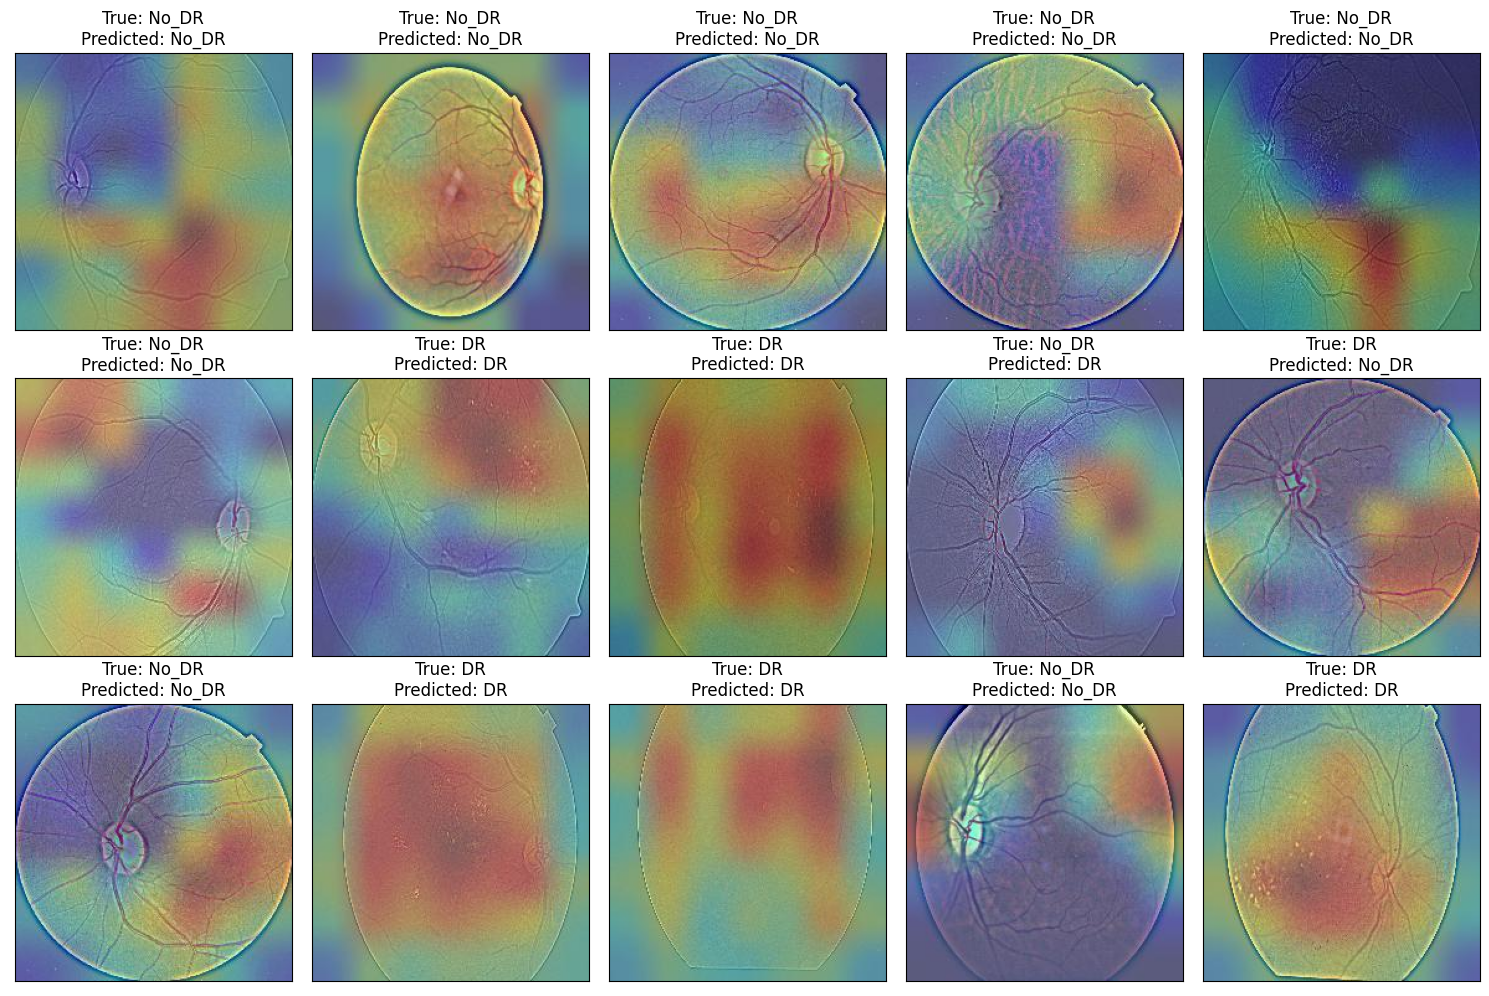

In [30]:
fig, axes = plt.subplots(
    nrows=3,
    ncols=5,
    figsize=(15, 10),
    subplot_kw={'xticks':[], 'yticks':[]})

for i, ax in enumerate(axes.flat):
    img_path = test_df.Filepath.iloc[i]
    img_array = preprocess_input(get_img_array(img_path, size=img_size))
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    cam_path = save_and_display_gradcam(img_path, heatmap)
    ax.imshow(plt.imread(cam_path))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")

plt.tight_layout()
plt.show()